## 1. Introdução e objetivo do projeto

* O objetivo desse projeto é criar um modelo de machine learning para estimar o preço de um veículo com base em suas características, utilizando o método K-nearest neighbors. A eficácia do modelo será medida com base na raiz do erro quadrado médio (root mean squared error). O Dataset utilizado pode ser baixado aqui https://archive.ics.uci.edu/ml/datasets/automobile


* Esse projeto foi desenvolvido por mim como parte do curso de "Machine Learning Introduction" do Dataquest, um site americano que oferece cursos pagos de ciência de dados. O Dataquest oferece projetos guiados ao término de cada módulo, onde os alunos aplicam os conceitos aprendidos no módulo. Nos projetos guiados são utilizados datasets reais e os alunos recebem instruções gerais de como resolver o problema proposto. O site oferece a "solução" para cada projeto guiado, que pode ser encontrada no seguinte link https://github.com/dataquestio/solutions/blob/master/Mission155Solutions.ipynb Como estou iniciando em data-science, obviamente tive que recorrer à solução disponibilizada pelo site, no entanto, escrevi meu próprio código e em várias etapas melhorei o código em relação à solução apresentada.




## 2. Importação das bibliotecas e leitura do dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

columns_names = ['symboling','normalized-losses','make','fuel-type','aspiration','num-of-doors','body-style','drive-wheels','engine-location','wheel-base','length','width','height','curb-weight','engine-type','num-of-cylinders','engine-size','fuel-system','bore','stroke','compression-ratio','horsepower','peak-rpm','city-mpg','highway-mpg','price']
cars = pd.read_csv('imports-85.data',names = columns_names)
rs = 1 #Random state que vamos usar ao longo da análise para manter a restrabilidade do código

In [2]:
cars.dtypes

symboling              int64
normalized-losses     object
make                  object
fuel-type             object
aspiration            object
num-of-doors          object
body-style            object
drive-wheels          object
engine-location       object
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type           object
num-of-cylinders      object
engine-size            int64
fuel-system           object
bore                  object
stroke                object
compression-ratio    float64
horsepower            object
peak-rpm              object
city-mpg               int64
highway-mpg            int64
price                 object
dtype: object

In [3]:
#Identificação das colunas numéricas
numeric_cols = cars.select_dtypes(include = ['int64','float64']).columns.values

#Removendo a coluna symboling, que não tem informações relevantes para nossa análise
#de acordo com o site onde foi disponibilizado o dataset, essa coluna traz informações sobre o risco
#associado ao tipo de veículo (o dataset original foi elaborado por uma seguradora)
numeric_cols = numeric_cols[numeric_cols != 'symboling']

In [4]:
#Analisando colunas não numéricas para ver se alguma contém informação numérica salva como string
cars.select_dtypes(include = 'object').sample(5)

,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,engine-type,num-of-cylinders,fuel-system,bore,stroke,horsepower,peak-rpm,price
54,113,mazda,gas,std,four,sedan,fwd,front,ohc,four,2bbl,3.08,3.15,68,5000,7395
30,137,honda,gas,std,two,hatchback,fwd,front,ohc,four,1bbl,2.91,3.41,58,4800,6479
10,192,bmw,gas,std,two,sedan,rwd,front,ohc,four,mpfi,3.50,2.80,101,5800,16430
108,161,peugot,diesel,turbo,four,sedan,rwd,front,l,four,idi,3.70,3.52,95,4150,13200
87,125,mitsubishi,gas,turbo,four,sedan,fwd,front,ohc,four,spdi,3.17,3.46,116,5500,9279


In [5]:
#Vemos que as colunas 'num-of-doors','num-of-cylinders','bore','stroke','horsepower','peak-rpm','price'
#apesar de estarem salvas como object na verdade representam valores numéricos, vamos incluí-las nas

numeric_cols = np.append(numeric_cols,['num-of-doors','num-of-cylinders','bore','stroke','horsepower','peak-rpm','price'])

## 3. Limpeza dos dados

In [6]:
#Alguns valores vazios estão como "?" no dataset, vamos substituílos por np.nan
cars = cars[numeric_cols]
test_missing = cars == "?"
test_missing.sum()

wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-size          0
compression-ratio    0
city-mpg             0
highway-mpg          0
num-of-doors         2
num-of-cylinders     0
bore                 4
stroke               4
horsepower           2
peak-rpm             2
price                4
dtype: int64

In [7]:
cars.replace("?",np.nan, inplace = True)

In [8]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   wheel-base         205 non-null    float64
 1   length             205 non-null    float64
 2   width              205 non-null    float64
 3   height             205 non-null    float64
 4   curb-weight        205 non-null    int64  
 5   engine-size        205 non-null    int64  
 6   compression-ratio  205 non-null    float64
 7   city-mpg           205 non-null    int64  
 8   highway-mpg        205 non-null    int64  
 9   num-of-doors       203 non-null    object 
 10  num-of-cylinders   205 non-null    object 
 11  bore               201 non-null    object 
 12  stroke             201 non-null    object 
 13  horsepower         203 non-null    object 
 14  peak-rpm           203 non-null    object 
 15  price              201 non-null    object 
dtypes: float64(5), int64(4), o

In [9]:
#As seguinte colunas já estão com números, e só precisam ser salvas como texto
cars[['bore','stroke','horsepower','peak-rpm','price']] = cars[['bore','stroke','horsepower','peak-rpm','price']].astype(float)
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   wheel-base         205 non-null    float64
 1   length             205 non-null    float64
 2   width              205 non-null    float64
 3   height             205 non-null    float64
 4   curb-weight        205 non-null    int64  
 5   engine-size        205 non-null    int64  
 6   compression-ratio  205 non-null    float64
 7   city-mpg           205 non-null    int64  
 8   highway-mpg        205 non-null    int64  
 9   num-of-doors       203 non-null    object 
 10  num-of-cylinders   205 non-null    object 
 11  bore               201 non-null    float64
 12  stroke             201 non-null    float64
 13  horsepower         203 non-null    float64
 14  peak-rpm           203 non-null    float64
 15  price              201 non-null    float64
dtypes: float64(10), int64(4), 

In [10]:
#Vamos substituir os números que estão salvos por números
cars['num-of-cylinders'].value_counts(dropna = False)

four      159
six        24
five       11
eight       5
two         4
twelve      1
three       1
Name: num-of-cylinders, dtype: int64

In [11]:
num_cyl = {'four':4,'six':6,'five':5,'eight':8,'two':2,'three':3,'twelve':12}
cars['num-of-cylinders'].replace(to_replace = num_cyl, inplace = True)
cars['num-of-cylinders'].value_counts(dropna = False) 

4     159
6      24
5      11
8       5
2       4
12      1
3       1
Name: num-of-cylinders, dtype: int64

In [12]:
cars['num-of-doors'].value_counts(dropna = False)

four    114
two      89
NaN       2
Name: num-of-doors, dtype: int64

In [13]:
cars['num-of-doors'].replace(to_replace = {'four':4,'two':2}, inplace = True)
cars['num-of-doors'].value_counts(dropna = False)

4.0    114
2.0     89
NaN      2
Name: num-of-doors, dtype: int64

In [14]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   wheel-base         205 non-null    float64
 1   length             205 non-null    float64
 2   width              205 non-null    float64
 3   height             205 non-null    float64
 4   curb-weight        205 non-null    int64  
 5   engine-size        205 non-null    int64  
 6   compression-ratio  205 non-null    float64
 7   city-mpg           205 non-null    int64  
 8   highway-mpg        205 non-null    int64  
 9   num-of-doors       203 non-null    float64
 10  num-of-cylinders   205 non-null    int64  
 11  bore               201 non-null    float64
 12  stroke             201 non-null    float64
 13  horsepower         203 non-null    float64
 14  peak-rpm           203 non-null    float64
 15  price              201 non-null    float64
dtypes: float64(11), int64(5)
m

In [15]:
#Avaliando os valores vazios em cada uma das colunas que possuem valores vazios
cars[cars['num-of-doors'].isnull()]

,wheel-base,length,width,height,curb-weight,engine-size,compression-ratio,city-mpg,highway-mpg,num-of-doors,num-of-cylinders,bore,stroke,horsepower,peak-rpm,price
27,93.7,157.3,63.8,50.6,2191,98,7.6,24,30,NaN,4,3.03,3.39,102.0,5500.0,8558.0
63,98.8,177.8,66.5,55.5,2443,122,22.7,36,42,NaN,4,3.39,3.39,64.0,4650.0,10795.0


In [16]:
cars[cars['bore'].isnull()]

,wheel-base,length,width,height,curb-weight,engine-size,compression-ratio,city-mpg,highway-mpg,num-of-doors,num-of-cylinders,bore,stroke,horsepower,peak-rpm,price
55,95.3,169.0,65.7,49.6,2380,70,9.4,17,23,2.0,2,NaN,NaN,101.0,6000.0,10945.0
56,95.3,169.0,65.7,49.6,2380,70,9.4,17,23,2.0,2,NaN,NaN,101.0,6000.0,11845.0
57,95.3,169.0,65.7,49.6,2385,70,9.4,17,23,2.0,2,NaN,NaN,101.0,6000.0,13645.0
58,95.3,169.0,65.7,49.6,2500,80,9.4,16,23,2.0,2,NaN,NaN,135.0,6000.0,15645.0


In [17]:
cars[cars['horsepower'].isnull()]

,wheel-base,length,width,height,curb-weight,engine-size,compression-ratio,city-mpg,highway-mpg,num-of-doors,num-of-cylinders,bore,stroke,horsepower,peak-rpm,price
130,96.1,181.5,66.5,55.2,2579,132,8.7,23,31,4.0,4,3.46,3.9,NaN,NaN,9295.0
131,96.1,176.8,66.6,50.5,2460,132,8.7,23,31,2.0,4,3.46,3.9,NaN,NaN,9895.0


In [18]:
cars[cars['price'].isnull()]

,wheel-base,length,width,height,curb-weight,engine-size,compression-ratio,city-mpg,highway-mpg,num-of-doors,num-of-cylinders,bore,stroke,horsepower,peak-rpm,price
9,99.5,178.2,67.9,52.0,3053,131,7.0,16,22,2.0,5,3.13,3.40,160.0,5500.0,NaN
44,94.5,155.9,63.6,52.0,1874,90,9.6,38,43,2.0,4,3.03,3.11,70.0,5400.0,NaN
45,94.5,155.9,63.6,52.0,1909,90,9.6,38,43,4.0,4,3.03,3.11,70.0,5400.0,NaN
129,98.4,175.7,72.3,50.5,3366,203,10.0,17,28,2.0,8,3.94,3.11,288.0,5750.0,NaN


In [19]:
a=12/205*100
a #Como as colunas com valores vazios representam apenas 5.85% do dataset, vamos excluí-las completamente

5.853658536585367

In [20]:
cars = cars.dropna()

In [21]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193 entries, 0 to 204
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   wheel-base         193 non-null    float64
 1   length             193 non-null    float64
 2   width              193 non-null    float64
 3   height             193 non-null    float64
 4   curb-weight        193 non-null    int64  
 5   engine-size        193 non-null    int64  
 6   compression-ratio  193 non-null    float64
 7   city-mpg           193 non-null    int64  
 8   highway-mpg        193 non-null    int64  
 9   num-of-doors       193 non-null    float64
 10  num-of-cylinders   193 non-null    int64  
 11  bore               193 non-null    float64
 12  stroke             193 non-null    float64
 13  horsepower         193 non-null    float64
 14  peak-rpm           193 non-null    float64
 15  price              193 non-null    float64
dtypes: float64(11), int64(5)
m

In [22]:
'''O modelo K-nearest neighbors calcula a distância euclidiana entre o ponto cujo valor queremos estimar,
    e todos os outros pontos do dataset. Para isso é preciso que todas as colunas do dataset estejam normalizadas,
    do contrário colunas com números maiores teriam um peso maior no cálculo da distância.
    Para normalizar a coluna, basta subtrair cada valor pela média de sua coluna, e dividí-lo pelo desvio padrão
    da coluna.'''
normalized_cars = (cars - cars.mean())/cars.std()
normalized_cars['price'] = cars['price'] #a nossa coluna alvo deve permacer a mesma, não faz senti normalizá-la

In [23]:
normalized_cars.sample(5)

,wheel-base,length,width,height,curb-weight,engine-size,compression-ratio,city-mpg,highway-mpg,num-of-doors,num-of-cylinders,bore,stroke,horsepower,peak-rpm,price
96,-0.719041,-0.723353,-0.979412,0.263095,-1.121146,-0.748353,-0.186959,0.888185,0.911327,0.848214,-0.410180,-0.663113,0.130429,-0.908371,0.213911,7499.0
111,1.458968,0.991584,1.172337,1.181763,0.974923,-0.195342,-0.438374,-0.990387,-0.995695,0.848214,-0.410180,0.474984,-3.356975,-0.223442,-0.212806,15580.0
92,-0.719041,-0.723353,-0.979412,0.263095,-1.183801,-0.748353,-0.186959,0.888185,0.911327,0.848214,-0.410180,-0.663113,0.130429,-0.908371,0.213911,6849.0
17,1.800297,1.816998,2.341766,1.014733,1.791327,1.944572,-0.538940,-1.616578,-1.582471,0.848214,1.544506,1.062388,0.447465,2.068438,0.640629,36880.0
143,-0.280188,-0.186433,-0.230977,-0.572058,-0.420558,-0.483870,-0.287525,0.105447,0.177857,0.848214,-0.410180,1.062388,-1.930310,-0.249785,0.213911,9960.0


## 4. Escolha das features com modelo K-Nearest Neighbors de uma variável

* Nosso dataset agora contem 15 features e precisamos escolher quais delas fazem mais sentido de serem usadas em nosso modelo. Para isso vamos primeiramente criar um modelo 'univariate', onde vamos testar cada feature individualmente.

* Para treinar e testar os modelos vamos utilizar o método de cross validation, com 5 folds. Ou seja, o nosso código vai dividir o dataset em 5 partes iguais e rodar 5 modelos. Em cada "rodada", 4/5 das linhas serão usadas para treinar o modelo e 1/5 para teste. Isso ajuda a evitar que tenhamos um resultado melhor ou pior, porque treinamos o modelo com uma fração específica do dataset. Para fazer isso vamos usar o método cross_val_score, com o parâmetro de scoring 'neg_mean_squared_error', cuja saída são os 5 valores de mean squared error entre os valores previstos e os reais para cada uma das 5 rodadas. O valor final para o modelo será a raiz da média desses modelos.

In [24]:
def univariate_knn_cross_fold(feature,df = normalized_cars,target = 'price',k = 5):   
    model = KNeighborsRegressor(n_neighbors = k)
    k_fold = KFold(n_splits=5, shuffle=True, random_state= rs)
    mses = cross_val_score(model,df[[feature]],df[[target]],scoring = 'neg_mean_squared_error', cv = k_fold)
    rmses = (np.absolute(mses))**0.5
    avg_rmse = np.mean(rmses)
    return avg_rmse

In [25]:
#Vamos fazer um for loop com cada feature e salvar em um dicionário cada feature e seu respectivo RMSE (root
#mean squared error)
#Inicialmente vamos usar um K de 5 "vizinhos"

feature_rmse = {}

for col in ['num-of-doors', 'wheel-base', 'length', 'width', 'height',
       'curb-weight', 'num-of-cylinders', 'engine-size', 'bore', 'stroke',
       'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
       'highway-mpg']:
    root_mean_squared_error = univariate_knn_cross_fold(df = normalized_cars,feature = col,target = 'price', k = 5)
    feature_rmse[col] = root_mean_squared_error

feature_rmse = pd.Series(feature_rmse)
feature_rmse = feature_rmse.sort_values()
feature_rmse

engine-size          3179.500756
horsepower           3965.815026
curb-weight          4139.620194
city-mpg             4172.737507
highway-mpg          4416.539895
width                4707.336966
length               5207.326031
wheel-base           5719.290972
compression-ratio    6683.751566
stroke               7302.688658
bore                 7585.908002
height               7608.255204
peak-rpm             7640.543271
num-of-cylinders     8334.652419
num-of-doors         8639.692651
dtype: float64

In [26]:
six_best_features = pd.Series(feature_rmse.index.values[0:6])
six_best_features

0    engine-size
1     horsepower
2    curb-weight
3       city-mpg
4    highway-mpg
5          width
dtype: object

* Chegamos à conclusão que as 6 melhores features são 'engine-size', 'horsepower', 'curb-weight', 'city-mpg',    'highway-mpg' e 'width'. No entanto chegamos a essa conclusão usando o valor de k = 5. Vamos agora plotar o RMSE para cada um dessas 6 features, variando o valor de K.

In [27]:
dict_feature_k_rmse= {}

for f in six_best_features:
    temp_feature_k_dict = {}
    for n_neighbors in range(1,11,1): #loop para variar o valor de K
        temp_feature_k_dict[n_neighbors] = univariate_knn_cross_fold(df = normalized_cars,feature = f,target = 'price', k = n_neighbors)
    dict_feature_k_rmse[f] =  temp_feature_k_dict 


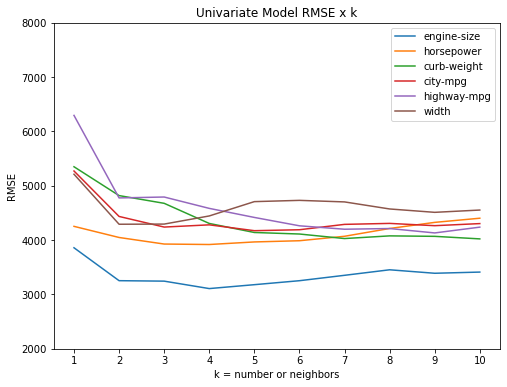

In [28]:
figure = plt.figure(figsize = [8,6])
ax1 = figure.add_subplot(1,1,1)

for key in dict_feature_k_rmse:
    x = range(1,11,1)
    y = list(dict_feature_k_rmse[key].values())
    ax1.plot(x,y, label = key)

ax1.legend()
ax1.set_xticks(range(1,11,1))
ax1.set_xlabel('k = number or neighbors')
ax1.set_ylabel('RMSE')
ax1.set_ylim(2000,8000)
ax1.set_title("Univariate Model RMSE x k")

plt.show()

* Agora vamos ordenar esses valores em função da média de desempenho do modelo para os valores de k que plotamos.

In [31]:
avg_rmse_feature = {}

for f in six_best_features:
    avg_rmse = np.average(list(dict_feature_k_rmse[f].values()))
    avg_rmse_feature[f] = avg_rmse

six_best_features = pd.Series(avg_rmse_feature).sort_values()
six_best_features #Notamos que ordenando as features pela média, a sequência mudou.

engine-size    3350.252909
horsepower     4111.076609
curb-weight    4359.695675
city-mpg       4375.203986
highway-mpg    4590.531005
width          4601.638003
dtype: float64

## 5. Modelo K Nearest Neighbors multivariável

* Agora que já definimos as 6 possíveis features do modelo, vamos ver como o modelo se comporta, utilizando mais de uma feature, e determinar quais os melhores hyperparameters para o modelo (ou seja, quantos vizinhos k devemos usar, e quantas features devemos usar.


In [32]:
def multivariate_knn_cross_fold(feature,df = normalized_cars,target = 'price',k = 5):   
    model = KNeighborsRegressor(n_neighbors = k)
    k_fold = KFold(n_splits=5, shuffle=True, random_state= rs)
    mses = cross_val_score(model,df[feature],df[[target]],scoring = 'neg_mean_squared_error', cv = k_fold)
    rmses = (np.absolute(mses))**0.5
    avg_rmse = np.mean(rmses)
    return avg_rmse

In [33]:
feature_rmse_cross_fold = {}

for i in range(1,6):
    features = six_best_features[0:i].keys().values
    k_per_feature_temp = {}
    for n_neighbors in range(1,11,1):
        k_per_feature_temp[n_neighbors] = multivariate_knn_cross_fold(feature = features, k = n_neighbors)
    feature_rmse_cross_fold[str(features)] = k_per_feature_temp
    
feature_rmse_cross_fold

{"['engine-size']": {1: 3858.5869848939556,
  2: 3253.0982338214644,
  3: 3244.618559197672,
  4: 3107.8055701172243,
  5: 3179.5007556120813,
  6: 3252.677890298296,
  7: 3351.913411215262,
  8: 3453.4707466024834,
  9: 3389.5750130382403,
  10: 3411.281924990897},
 "['engine-size' 'horsepower']": {1: 3297.1802217275485,
  2: 2844.8506969034343,
  3: 2930.005981681948,
  4: 2964.0620957221763,
  5: 3068.072893566577,
  6: 3148.062653634363,
  7: 3172.090674241893,
  8: 3258.674023340924,
  9: 3349.5290928795102,
  10: 3473.4391585078033},
 "['engine-size' 'horsepower' 'curb-weight']": {1: 2803.888388557465,
  2: 2650.0988908712648,
  3: 2923.890674311194,
  4: 3047.934223549778,
  5: 3273.083408811743,
  6: 3343.3920234399397,
  7: 3371.930398934447,
  8: 3520.656541024203,
  9: 3644.2885759306637,
  10: 3740.856114037519},
 "['engine-size' 'horsepower' 'curb-weight' 'city-mpg']": {1: 2679.1105281932637,
  2: 2448.297214749308,
  3: 2777.594988782325,
  4: 2890.4949605219554,
  5: 305

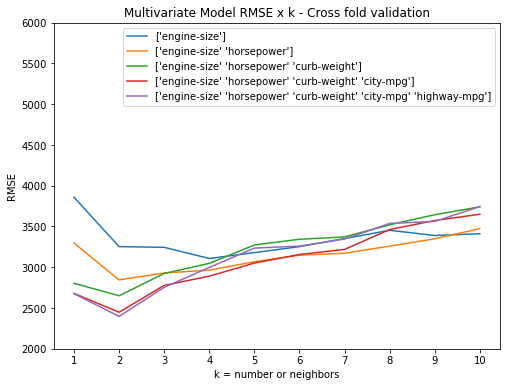

In [34]:
%matplotlib inline
figure3 = plt.figure(figsize = [8,6])
ax3 = figure3.add_subplot(1,1,1)

for key in feature_rmse_cross_fold:
    x = list(feature_rmse_cross_fold[key].keys())
    y = list(feature_rmse_cross_fold[key].values())
    ax3.plot(x,y, label = key)

ax3.legend()
ax3.set_xlabel('k = number or neighbors')
ax3.set_ylabel('RMSE')
ax3.set_ylim(2000,6000)
ax3.set_title("Multivariate Model RMSE x k - Cross fold validation")
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.show()

In [47]:
features = six_best_features.keys().values[:4]
rmse = multivariate_knn_cross_fold(feature = features, k = 2)

print("Features: {}".format(features))
print("number of neighbors k: {}".format(2))
print("root mean squared error: {}".format(round(rmse,2)))

Features: ['engine-size' 'horsepower' 'curb-weight' 'city-mpg']
number of neighbors k: 2
root mean squared error: 2448.3


## 6. Conclusões e considerações finais

* **Melhores hyperparameters:** Pelo gráfico acima, podemos ver que o melhor modelo seria aquele com k = 2 e com as features engine-size, horsepower, curb-weight, city-mpg e highway-mpg. No entanto, como city-mpg e highway-mpg são muito parecidos (consumo de combustível na cidade e na estrada),o ideal seria utilizar apenas uma das features, sendo assim, **o modelo com 4 features (engine-size, horsepower, curb-weight, city-mpg) e k = 2 é o mais recomendado**.

* **Bias vs Variance**: Em um modelo de k-nearest neightbors, a medida que aumentamos o valor de features aumentamos a variância (e diminuímos o bias) do modelo, aumentando a probabilidade de overfitting. Sendo assim, como a diferença entre o modelo de 4 e 5 features foi pequena, temos mais um motivo para usar 4 features. Em relação ao número de vizinhos, k, a medida que aumentamos k aumentamos o bias (e diminuímos a variância). O gráfico acima claramente indica que o erro é menor com k = 2.

* **Utilização de K Nearest Neighbors (KNN)**: O uso de KNN faz sentido para esse dataset pois temos poucas linhas (193). Caso tivéssemos muitas linhas precisariamos de usar outro tipo de modelo (como regressão linear), pois o KNN treina o modelo cada vez que precisamos fazer uma estimativa (já que ele precisa de calcular e ordenar as distâncias entre o novo pontos e todo o dataset), o que leva tempo. Em um modelo de regressão linar por exemplo, uma vez treinado podemos facilmente fazer novas previsões (sem precisar rodar o fit novamente).
